In [25]:
import pandas as pd
import pandasql as ps
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
pozos = pd.read_csv("pozos-con-geo-info.csv")
produccion = pd.read_csv("produccin-de-pozos-de-gas-y-petrleo-2024.csv")


/var/folders/r_/x2vzgchn7xg93cptq09838d91bmbgx/T/ipykernel_5407/3577868358.py:2: DtypeWarning: Columns (16,36) have mixed types. Specify dtype option on import or set low_memory=False.
  produccion = pd.read_csv("produccin-de-pozos-de-gas-y-petrleo-2024.csv")


In [27]:
consulta_gas_sql = """
SELECT sigla, SUM(prod_gas) as gas_sum
FROM produccion
GROUP BY sigla
HAVING SUM(prod_gas) > 0
ORDER BY gas_sum
"""

consulta_petroleo_sql = """
SELECT sigla, SUM(prod_pet) as pet_sum
FROM produccion
GROUP BY sigla
HAVING SUM(prod_pet) > 0
ORDER BY prod_pet
"""

sum_gas = ps.sqldf(consulta_gas_sql, locals())
sum_pet = ps.sqldf(consulta_petroleo_sql, locals())

# Analisis de gas

Cuartil 1 (Q1): 19.0039315
Mediana (Q2): 67.315
Cuartil 3 (Q3): 467.39746

Resumen estadístico:
count    2.052200e+04
mean     3.018719e+03
std      3.702943e+04
min      6.000000e-06
25%      1.900393e+01
50%      6.731500e+01
75%      4.673975e+02
max      2.651588e+06
Name: gas_sum, dtype: float64
Upper whisker: 1139.60732


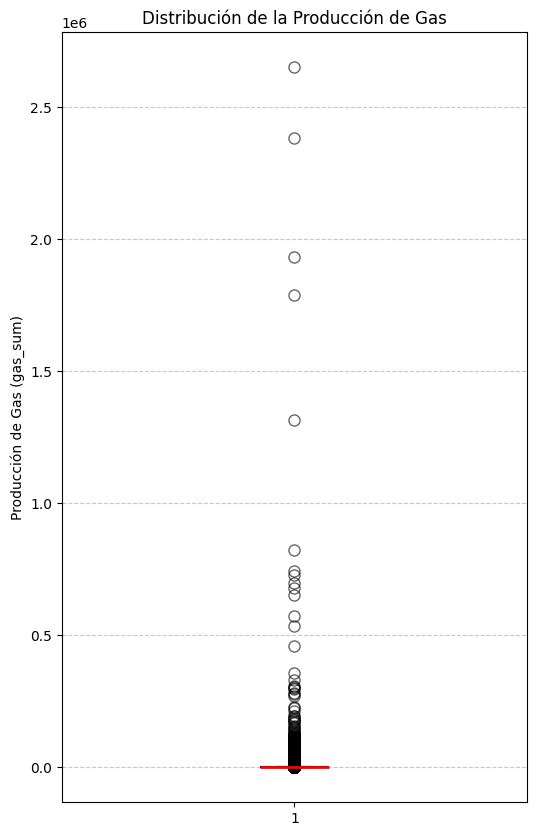

In [46]:
# Calcular los cuartiles
cuartiles_gas = np.percentile(sum_gas['gas_sum'], [25, 50, 75])

print(f"Cuartil 1 (Q1): {cuartiles_gas[0]}")
print(f"Mediana (Q2): {cuartiles_gas[1]}")
print(f"Cuartil 3 (Q3): {cuartiles_gas[2]}")

# Resumen estadístico
print("\nResumen estadístico:")
print(sum_gas['gas_sum'].describe())

# Visualización de la distribución
plt.figure(figsize=(6, 10))
boxplot_data = plt.boxplot(
    sum_gas['gas_sum'],
    vert=True,
    patch_artist=True,  # Permite rellenar la caja
    boxprops=dict(facecolor="skyblue", edgecolor="black", linewidth=1.5),  # Caja azul clara con borde negro
    medianprops=dict(color="red", linewidth=2),  # Mediana en rojo
    whiskerprops=dict(color="black", linewidth=1.5),  # Bigotes en negro
    capprops=dict(color="black", linewidth=1.5),  # Límites de los bigotes
    flierprops=dict(marker='o', color='red', markersize=8, alpha=0.6)  # Valores atípicos en rojo
)
upper_whisker = boxplot_data['whiskers'][1].get_ydata()[1]  # El segundo bigote
print(f"Upper whisker: {upper_whisker}")
plt.title("Distribución de la Producción de Gas")
plt.ylabel("Producción de Gas (gas_sum)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Escala logaritmica

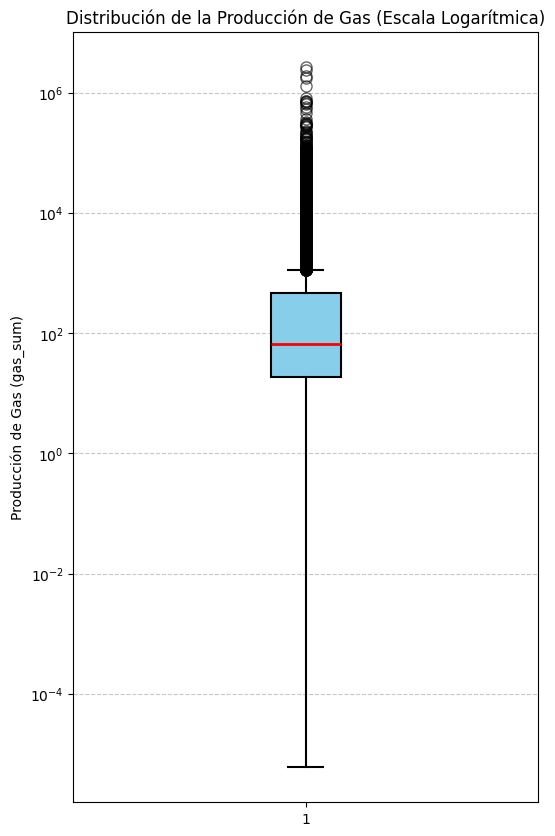

In [47]:
# Visualización de la distribución (logarítmica)
plt.figure(figsize=(6, 10))
plt.boxplot(
    sum_gas['gas_sum'],
    vert=True,
    patch_artist=True,
    boxprops=dict(facecolor="skyblue", edgecolor="black", linewidth=1.5),
    medianprops=dict(color="red", linewidth=2),
    whiskerprops=dict(color="black", linewidth=1.5),
    capprops=dict(color="black", linewidth=1.5),
    flierprops=dict(marker='o', color='red', markersize=8, alpha=0.6)
)

plt.yscale('log')  # Escala logarítmica
plt.title("Distribución de la Producción de Gas (Escala Logarítmica)")
plt.ylabel("Producción de Gas (gas_sum)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


8444.608000000007
20522
19495


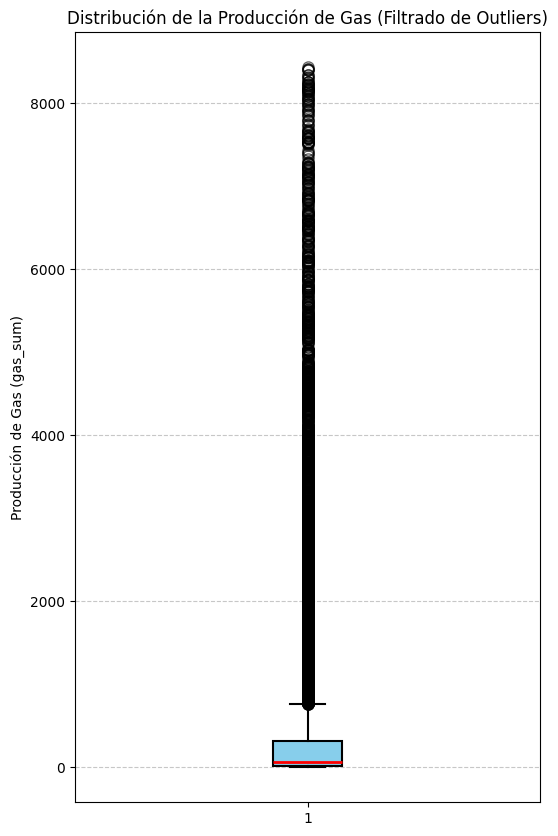

In [48]:
# Filtrar valores superiores al percentil 95
threshold = np.percentile(sum_gas['gas_sum'], 95)
print(threshold)
print(len(sum_gas))
filtered_data = sum_gas[sum_gas['gas_sum'] <= threshold]
print(len(filtered_data))
# Visualización de datos filtrados
plt.figure(figsize=(6, 10))
plt.boxplot(
    filtered_data['gas_sum'],
    vert=True,
    patch_artist=True,
    boxprops=dict(facecolor="skyblue", edgecolor="black", linewidth=1.5),
    medianprops=dict(color="red", linewidth=2),
    whiskerprops=dict(color="black", linewidth=1.5),
    capprops=dict(color="black", linewidth=1.5),
    flierprops=dict(marker='o', color='red', markersize=8, alpha=0.6)
)

plt.title("Distribución de la Producción de Gas (Filtrado de Outliers)")
plt.ylabel("Producción de Gas (gas_sum)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Rango intercuartil

## Con outliers

In [64]:
Q3 = np.percentile(sum_gas['gas_sum'], 75)

# >Q3
intercuartil_alto = sum_gas[(sum_gas['gas_sum'] >= Q3)]

# Crear la lista de siglas de los valores intercuartil altos
siglas_alto = intercuartil_alto['sigla'].tolist()  # Convertir la columna 'sigla' en una lista

# Pasar la lista a la consulta SQL
consulta_pozos_int_alto = f"""
SELECT sigla, formacion, tipo_recurso
FROM pozos
WHERE sigla IN ({', '.join(f"'{sigla}'" for sigla in siglas_alto)})
"""

# Ejecutar la consulta con pandasql
pozos_int_alto = ps.sqldf(consulta_pozos_int_alto, locals())

print(pozos_int_alto)

convencional_sql = f"""
SELECT tipo_recurso, count(*) as cant
FROM pozos_int_alto
GROUP BY tipo_recurso
ORDER BY cant desc
"""
formacion_sql = f"""
SELECT formacion, count(*) as cant
FROM pozos_int_alto
GROUP BY formacion
ORDER BY cant desc
"""
formacion_tipo_sql = f"""
SELECT tipo_recurso, formacion, count(*) as cant
FROM pozos_int_alto
GROUP BY tipo_recurso, formacion
ORDER BY cant desc
"""

# Ejecutar la consulta con pandasql
pozos_int_alto_group = ps.sqldf(convencional_sql, locals())
print(pozos_int_alto_group)
pozos_int_alto_group = ps.sqldf(formacion_sql, locals())
print(pozos_int_alto_group)

pozos_int_alto_group = ps.sqldf(formacion_tipo_sql, locals())
print(pozos_int_alto_group)



                   sigla           formacion     tipo_recurso
0       YPF.SC.ELMa. x-1  comodoro rivadavia     CONVENCIONAL
1      A.SC.ELMa. e-1002  comodoro rivadavia     CONVENCIONAL
2           YPF.Ch.MMO-3            castillo     No informado
3         PCR.LP.EM-2084            quintuco     CONVENCIONAL
4         PCR.LP.EM-2086            quintuco     CONVENCIONAL
...                  ...                 ...              ...
5880  YPF.Nq.LLL-1798(h)         vaca muerta  NO CONVENCIONAL
5881  YPF.Nq.LLL-1799(h)         vaca muerta  NO CONVENCIONAL
5882  YPF.Nq.LLL-1800(h)         vaca muerta  NO CONVENCIONAL
5883     TAU.MA.Fen-5(h)          springhill     CONVENCIONAL
5884    YPF.Nq.EOr-30(h)         vaca muerta  NO CONVENCIONAL

[5885 rows x 3 columns]
      tipo_recurso  cant
0  NO CONVENCIONAL  2849
1     CONVENCIONAL  2425
2     No informado   610
3   SIN RESERVORIO     1
                 formacion  cant
0              vaca muerta  1642
1                    lajas   676
2      

## Sin outliers

Valores intercuartil alto:
                sigla     gas_sum
9748    YPF.RN.EM-747   58.332821
9749   YPF.SC.LP-2466   58.340000
9750   YPF.SC.CS-2178   58.340000
9751   YPF.SC.LP-1749   58.360000
9752   YPF.SC.LP-1943   58.360000
...               ...         ...
14616  YPF.SC.ECh-362  316.040000
14617  YPF.SC.LP-2179  316.160000
14618  PBE.SCA.CBo-39  316.417000
14619     YPF.SC.O-36  316.440000
14620  PEL.RN.EM-2004  316.531113

[4873 rows x 2 columns]


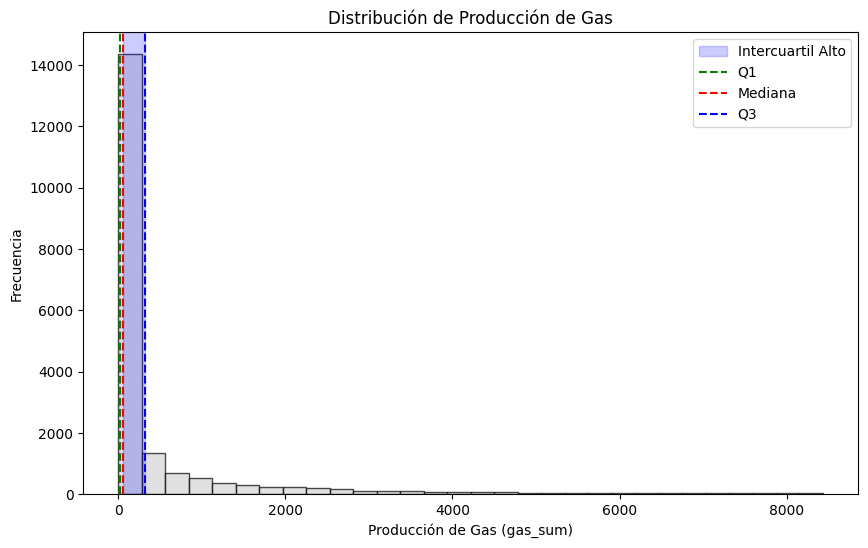

In [51]:
# Calcular Q1, Q3 y el IQR
Q1 = np.percentile(filtered_data['gas_sum'], 25)
Q3 = np.percentile(filtered_data['gas_sum'], 75)
IQR = Q3 - Q1

# Filtrar valores en el rango intercuartil alto (entre la mediana y Q3)
intercuartil_alto = filtered_data[(filtered_data['gas_sum'] > np.median(filtered_data['gas_sum'])) & 
                                  (filtered_data['gas_sum'] <= Q3)]

print("Valores intercuartil alto:")
print(intercuartil_alto)
plt.figure(figsize=(10, 6))
plt.hist(filtered_data['gas_sum'], bins=30, color='lightgray', edgecolor='black', alpha=0.7)

# Resaltar rango intercuartil alto
plt.axvspan(np.median(filtered_data['gas_sum']), Q3, color='blue', alpha=0.2, label="Intercuartil Alto")

# Líneas para Q1, Q2 (mediana), Q3
plt.axvline(Q1, color='green', linestyle='--', label="Q1")
plt.axvline(np.median(filtered_data['gas_sum']), color='red', linestyle='--', label="Mediana")
plt.axvline(Q3, color='blue', linestyle='--', label="Q3")

plt.title("Distribución de Producción de Gas")
plt.xlabel("Producción de Gas (gas_sum)")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()


                  sigla           formacion     tipo_recurso
0        CH.CH.EaLE.x-1  comodoro rivadavia     CONVENCIONAL
1         CH.CH.EaLE-15  comodoro rivadavia     CONVENCIONAL
2         CH.CH.EaLE-17  comodoro rivadavia     CONVENCIONAL
3        CLE.Ch.CN-1003        bajo barreal     No informado
4           CLE.Ch.CN-5        bajo barreal     No informado
...                 ...                 ...              ...
5874   YPF.Nq.LajE-6(h)         vaca muerta  NO CONVENCIONAL
5875     YPF.SC.EC-1560        cañadon seco     CONVENCIONAL
5876  SHE.Nq.SB-1047(h)         vaca muerta  NO CONVENCIONAL
5877   CGC.SCA.ECN.a-15          magallanes  NO CONVENCIONAL
5878      PC.LP.EM-1211             choiyoi     CONVENCIONAL

[5879 rows x 3 columns]


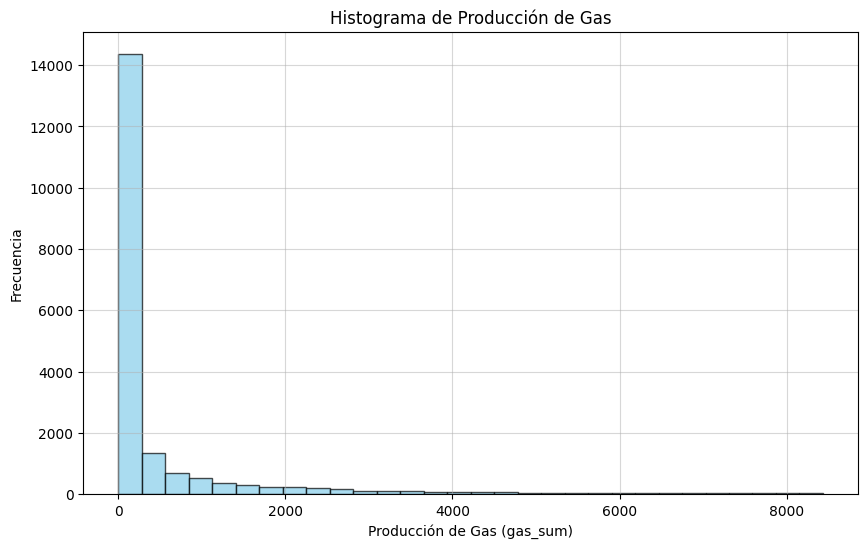

In [38]:
plt.figure(figsize=(10, 6))
plt.hist(filtered_data['gas_sum'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histograma de Producción de Gas")
plt.xlabel("Producción de Gas (gas_sum)")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.5)
plt.show()

Cuartil 1 (Q1): 175.45
Mediana (Q2): 403.56
Cuartil 3 (Q3): 887.5656375

Resumen estadístico:
count     25390.000000
mean       1335.482877
std        4033.766498
min           0.000001
25%         175.450000
50%         403.560000
75%         887.565637
max      118449.696000
Name: pet_sum, dtype: float64


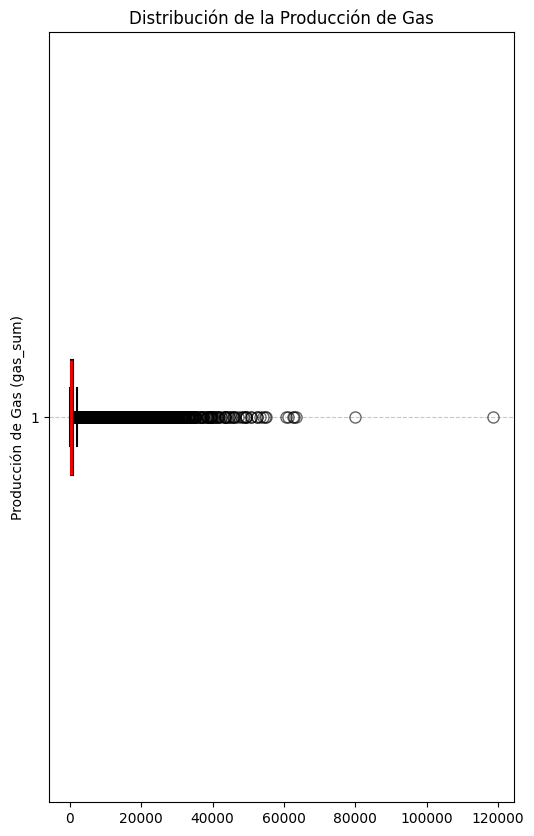

In [15]:
# Calcular los cuartiles
cuartiles_pet = np.percentile(sum_pet['pet_sum'], [25, 50, 75])

print(f"Cuartil 1 (Q1): {cuartiles_pet[0]}")
print(f"Mediana (Q2): {cuartiles_pet[1]}")
print(f"Cuartil 3 (Q3): {cuartiles_pet[2]}")

# Resumen estadístico
print("\nResumen estadístico:")
print(sum_pet['pet_sum'].describe())

# Visualización de la distribución
plt.figure(figsize=(6, 10))
plt.boxplot(
    sum_pet['pet_sum'],
    vert=False,
    patch_artist=True,  # Permite rellenar la caja
    boxprops=dict(facecolor="skyblue", edgecolor="black", linewidth=1.5),  # Caja azul clara con borde negro
    medianprops=dict(color="red", linewidth=2),  # Mediana en rojo
    whiskerprops=dict(color="black", linewidth=1.5),  # Bigotes en negro
    capprops=dict(color="black", linewidth=1.5),  # Límites de los bigotes
    flierprops=dict(marker='o', color='red', markersize=8, alpha=0.6)  # Valores atípicos en rojo
)
plt.title("Distribución de la Producción de Gas")
plt.ylabel("Producción de Gas (gas_sum)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

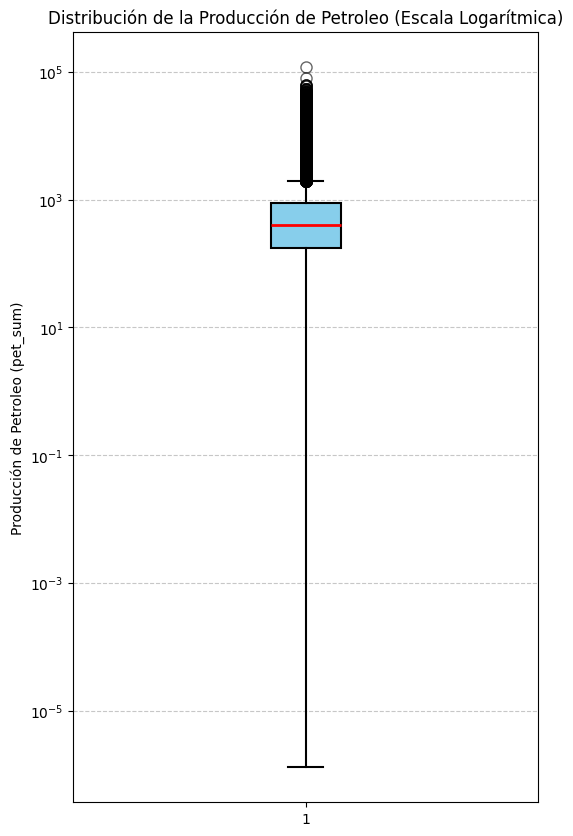

In [18]:
# Visualización de la distribución (logarítmica)
plt.figure(figsize=(6, 10))
plt.boxplot(
    sum_pet['pet_sum'],
    vert=True,
    patch_artist=True,
    boxprops=dict(facecolor="skyblue", edgecolor="black", linewidth=1.5),
    medianprops=dict(color="red", linewidth=2),
    whiskerprops=dict(color="black", linewidth=1.5),
    capprops=dict(color="black", linewidth=1.5),
    flierprops=dict(marker='o', color='red', markersize=8, alpha=0.6)
)

plt.yscale('log')  # Escala logarítmica
plt.title("Distribución de la Producción de Petroleo (Escala Logarítmica)")
plt.ylabel("Producción de Petroleo (pet_sum)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()